In [1]:
import numpy as np
import mne

from hdf5storage import loadmat, savemat 
from mne.minimum_norm import make_inverse_operator, apply_inverse, compute_source_psd_epochs, write_inverse_operator

from matplotlib import pyplot as plt


In [2]:
outdict=loadmat('preprocessed_eeg.mat')
outdict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'ch_bad', 'ch_dubious', 'ch_labels', 'chanlocs', 'preprocessed_eeg', 'subject_ID'])

In [3]:
preprocessed_eeg=outdict['preprocessed_eeg']*0.000001 # reduce the amplitube to be shown on MNE's plot
sampling_freq=outdict['Fs'][0]
ch_bad=outdict['ch_bad'][0]-1
ch_dubious=outdict['ch_dubious'][0]-1
subject_ID=outdict['subject_ID'][0]

n_channels=np.shape(preprocessed_eeg)[0]
ch_info_bads=np.concatenate((ch_bad, ch_dubious), axis=0)

In [4]:
ch_names = [f"E{n}" for n in range(1, 257)]
ch_types = ["eeg"] * n_channels
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
info.set_montage("GSN-HydroCel-256",match_case=False,match_alias=False,on_missing='raise')
info["description"] = subject_ID
print(info)

<Info | 9 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 256 EEG
 custom_ref_applied: False
 description: DAON
 dig: 259 items (3 Cardinal, 256 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 256
 projs: []
 sfreq: 1000.0 Hz
>


In [5]:
outdict=loadmat('./egi_xyz.mat')
Coordinates=outdict['Coordianates']/1000
for ch in range(3,len(info['dig'])):
    info['dig'][ch]['r']=Coordinates[ch-3,:]

In [6]:
ch_labels_info_bads=list()
for k in range(len(ch_info_bads)):
    ch_labels_info_bads.append(ch_names[k])

info['bads'] = ch_labels_info_bads

In [7]:
raw = mne.io.RawArray(preprocessed_eeg, info)
raw.set_eeg_reference('average', projection=True)
# raw.plot(show_scrollbars=False, show_scalebars=False)

Creating RawArray with float64 data, n_channels=256, n_times=182000
    Range : 0 ... 181999 =      0.000 ...   181.999 secs
Ready.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated


Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


<RawArray | 256 x 182000 (182.0 s), ~355.8 MB, data loaded>

In [8]:
# raw.save("raw.fif",overwrite=True)

forward solution

In [9]:
# the raw file containing the channel location + types
raw_fname = './raw.fif'

# The paths to Freesurfer reconstructions
subjects_dir ='../../archive/subjects/'
subject = 'fsaverage' # change it to use freesurfer's bem
# Compute Source Space (surface)
src = mne.setup_source_space(subject, spacing='ico3', add_dist='patch',
                             subjects_dir=subjects_dir)

conductivity = (0.3, 0.0075, 0.3)  #  three layers for EEG (MNE default  (0.3 0.006 0.3) )
model = mne.make_bem_model(subject=subject, ico=3,
                           conductivity=conductivity,
                           subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)




trans = './egi_trans.fif'

fwd = mne.make_forward_solution(raw_fname, trans=trans, src=src, bem=bem,
                                meg=False, eeg=True, mindist=5.0, n_jobs=2,
                                verbose=True)
print(fwd)

Setting up the source space with the following parameters:

SUBJECTS_DIR = /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_streamline_DOAN/../../archive/subjects
Subject      = fsaverage
Surface      = white
Icosahedron subdivision grade 3

>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_streamline_DOAN/../../archive/subjects/fsaverage/surf/lh.white...
Mapping lh fsaverage -> ico (3) ...
    Triangle neighbors and vertex normals...
Loading geometry from /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_streamline_DOAN/../../archive/subjects/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 642/163842 selected to source space (ico = 3)

Loading /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_streamline_DOAN/../../archive/subjects/fsaverage/surf/rh.white...
Mapping rh fsaverage -> ico (3) ...

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    Found   0/485 points outside using solid angles
    Total 642/642 points inside the surface
Interior check completed in 5673.8 ms
Checking surface interior status for 642 points...
    Found 147/642 points inside  an interior sphere of radius   48.4 mm
    Found   0/642 points outside an exterior sphere of radius   97.8 mm
    Found   0/495 points outside using surface Qhull
    Found   0/495 points outside using solid angles
    Total 642/642 points inside the surface
Interior check completed in 88.3 ms

Setting up for EEG...


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    5.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


Computing EEG at 1284 source locations (free orientations)...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.



Finished.
<Forward | MEG channels: 0 | EEG channels: 256 | Source space: Surface with 1284 vertices | Source orientation: Free>


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished


In [10]:
fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                         use_cps=True)
leadfield = fwd_fixed['sol']['data']
source_rr=fwd_fixed['source_rr']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Leadfield size : 256 sensors x 1284 dipoles


In [11]:
mne.write_forward_solution('fwd.fif', fwd_fixed, overwrite=True, verbose=None)

Overwriting existing file.
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written


/tmp/ipykernel_3496379/1225453021.py:1: RuntimeWarning: This filename (fwd.fif) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  mne.write_forward_solution('fwd.fif', fwd_fixed, overwrite=True, verbose=None)
/tmp/ipykernel_3496379/1225453021.py:1: RuntimeWarning: This forward solution is based on a forward solution with free orientation. The original forward solution is stored on disk in X/Y/Z RAS coordinates. Any transformation (surface orientation or fixed orientation) will be reverted. To reapply any transformation to the forward operator please apply convert_forward_solution after reading the forward solution with read_forward_solution.
  mne.write_forward_solution('fwd.fif', fwd_fixed, overwrite=True, verbose=None)


inv

In [12]:
# use the entire data as empty room noise
noise_cov = mne.compute_raw_covariance(raw)
noise_cov_mat=noise_cov['data']# it only included the good chans
# compute the average of the diagonal
# construct the scale of the noise cov
scale=0.05 # 1% 5% 10% *******************************************************************************
scale_ave=np.mean(noise_cov_mat.diagonal())*0.01
sim_cov_mat=np.zeros((np.shape(noise_cov_mat)))
for i in range(np.shape(sim_cov_mat)[0]):
       sim_cov_mat[i,i]=scale_ave


Using up to 910 segments
Number of samples used : 182000
[done]


In [13]:
sim_cov=noise_cov.copy()
sim_cov['data']=sim_cov_mat
# mne.write_cov('sim_cov.fif', sim_cov, overwrite=True, verbose=None)

In [14]:
nepochs=int(np.floor(np.shape(preprocessed_eeg)[1]/sampling_freq))
epochs_mat = np.column_stack(
    (
        np.arange(0, np.shape(preprocessed_eeg)[1], sampling_freq),
        np.zeros(nepochs, dtype=int),
        np.array([1]*nepochs),
    )
)

epoch_dict = dict(resting=1)
epochs = mne.Epochs(raw, epochs_mat, tmin=0, tmax=0.999, event_id=epoch_dict, preload=True, baseline=(None, None))

evoked = epochs["resting"].average()
mne.write_evokeds('resting_ave.fif', evoked, on_mismatch='raise', overwrite=True, verbose=None)
evokeds = mne.read_evokeds('./resting_ave.fif')
resting = evokeds[0]

Not setting metadata
182 matching events found
Setting baseline interval to [0.0, 0.999] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 182 events and 1000 original time points ...


0 bad epochs dropped
Overwriting existing file.
Reading /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_streamline_DOAN/resting_ave.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 194) active
    Found the data of interest:
        t =       0.00 ...     999.00 ms (resting)
        0 CTF compensation matrices available
        nave = 182 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Loaded Evoked data is baseline-corrected (baseline: [0, 0.999] sec)


In [15]:
# fwd = mne.read_forward_solution('fwd.fif')
mne.convert_forward_solution(fwd, surf_ori=True, copy=False)

    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]


Good channels,256 EEG
Bad channels,"E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, E15, E16, E17, E18, E19, E20, E21, E22, E23, E24, E25, E26, E27, E28, E29, E30, E31, E32, E33, E34, E35, E36, E37, E38, E39, E40, E41, E42, E43, E44, E45, E46, E47, E48, E49, E50, E51, E52, E53, E54, E55, E56, E57, E58, E59, E60, E61, E62, E63, E64, E65, E66"
Source space,Surface with 1284 vertices
Source orientation,Free


In [16]:
# Compute the source estimate (Fixed dipole orientations)
depth=2 # 1 2 4
inverse_operator = make_inverse_operator(resting.info, fwd, sim_cov, depth=depth, fixed=True)
# save the inverse operator and the inverse matrix
# write_inverse_operator('inv.fif', inverse_operator,overwrite=True)

info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 194 channels.
    194 out of 256 channels remain after picking
Selected 194 channels
Creating the depth weighting matrix...
    194 EEG channels
    limit = 1285/1284 = 2.428258
    scale = 262275 exp = 2
    Picked elements from a free-orientation depth-weighting prior into the fixed-orientation one
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.2e-16 (2.2e-16 eps * 194 dim * 0.0028  max singular value)
    Estimated rank (eeg): 193
    EEG: rank 193 computed from 194 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source co

In [17]:
%run extract_invmat.ipynb # run this script to load the functions needed to extract inverse matrix

In [18]:
method = "MNE"  # (could also be dSPM or sLORETA)
invmat=_get_matrix_from_inverse_operator(inverse_operator,fwd,method=method,lambda2=1.0/9.0)
np.shape(invmat)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 193 (1 small eigenvalues omitted)
Applying inverse operator to ""...
    Picked 194 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  15.4% variance
[done]
Dimension of Inverse Matrix: (1284, 194)


(1284, 194)

Correlation

In [19]:
original_eeg=np.delete(preprocessed_eeg,ch_info_bads,0)

In [20]:
source_data=np.matmul(invmat,original_eeg)

In [21]:
EEG_recon=np.matmul(leadfield,source_data)

(-2e-05, 2e-05)

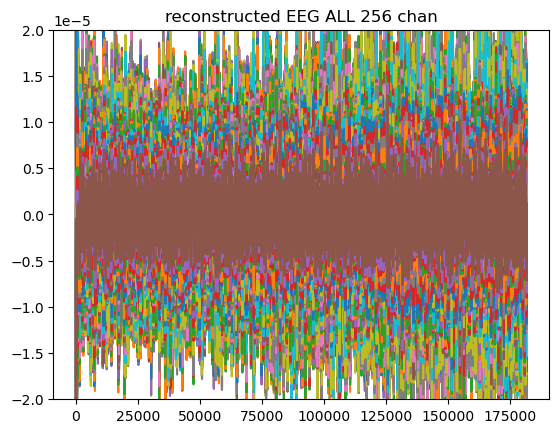

In [22]:
plt.plot(np.arange(0,np.shape(EEG_recon)[1],1),EEG_recon.transpose())
plt.title('reconstructed EEG ALL 256 chan')
plt.ylim([-2e-5,2e-5])
# 16 s

(-2e-05, 2e-05)

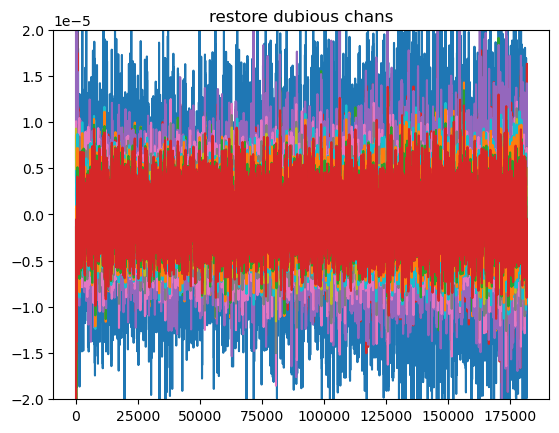

In [23]:
# look at dubious chan
plt.plot(np.arange(0,np.shape(EEG_recon)[1],1),EEG_recon[ch_dubious,:].transpose())
plt.title('restore dubious chans')
plt.ylim([-2e-5,2e-5])
# 3 s

(-2e-05, 2e-05)

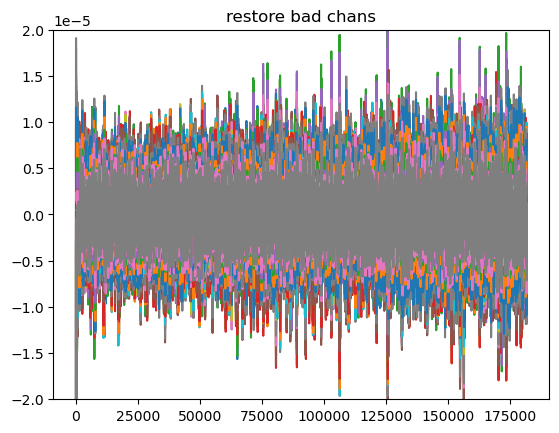

In [24]:
# look at bad chan
plt.plot(np.arange(0,np.shape(EEG_recon)[1],1),EEG_recon[ch_bad,:].transpose())
plt.title('restore bad chans')
plt.ylim([-2e-5,2e-5])
# 3 s

In [25]:
corr = np.corrcoef(EEG_recon, preprocessed_eeg, rowvar=True)

/home/zhibinz2/anaconda3/envs/mne/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/zhibinz2/anaconda3/envs/mne/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Text(0, 0.5, 'corrcoef')

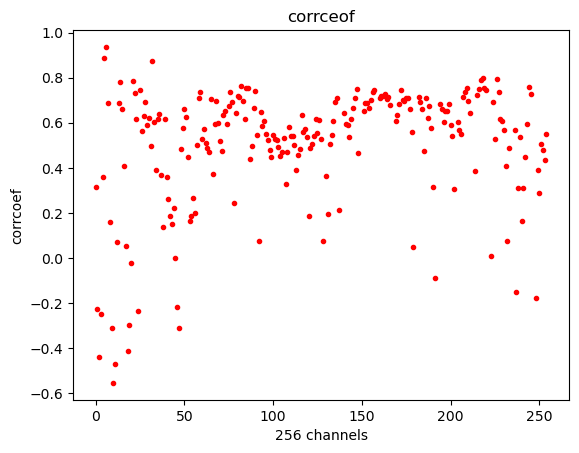

In [26]:
corrcoef256=np.zeros((256))
for i in range(256):
    corrcoef256[i]=corr[i,208+i]
plt.plot(corrcoef256,'r.')
plt.title('corrceof')
plt.xlabel('256 channels')
plt.ylabel('corrcoef')

In [27]:
# save outputs all in one mat file. 
outdict=dict()
outdict['leadfield']=leadfield # leadfield matrix
outdict['invmat']=invmat #  inverse matrix
outdict['source_rr']=source_rr # the source location AND labels (matlab)
outdict['sim_cov_mat']=sim_cov_mat # noise covariance
outdict['scale']=scale # scale
outdict['depth']=depth # depth
outdict['conductivity']=conductivity # 3 layrs conductivity


outdict['ch_bad']=ch_bad #  inverse matrix
outdict['ch_dubious']=ch_dubious # 
outdict['ch_names']=ch_names #  
outdict['Coordinates']=Coordinates #  
outdict['corrcoef256']=corrcoef256 #  
outdict['subject_ID']=subject_ID #  

savemat(subject_ID+'_scale_'+str(scale)+'_depth_'+str(depth),outdict)